# Simple example of Hamiltonian Monte Carlo (HMC) using NumPyro and JAX

In [1]:
import jax
from jax import jit, grad, hessian, vmap
from jax.lax import cond
import jax.numpy as jnp
import jax.random as jr
# import jax.scipy as js

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from corner import corner

In [2]:
# see what CPU / GPU devices are available
jax.devices()

[CpuDevice(id=0)]

In [3]:
# remove 'cpu' here to run on a GPU if available
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

# run in single precision
from jax import config
config.update('jax_debug_nans', False)
config.update('jax_enable_x64', False)

# Make fake data (sine curve with i.i.d. Gaussian noise)

The signal model in the time-domain is

\begin{equation}
\mathbf{h}(A, f, \phi) = A\sin(2\pi f\mathbf{t} - \phi)
\end{equation}

and the $i^\text{th}$ noise sample is drawn from a zero-mean Gaussian distribution, $n_i\sim\mathcal{N}(0, \sigma)$.

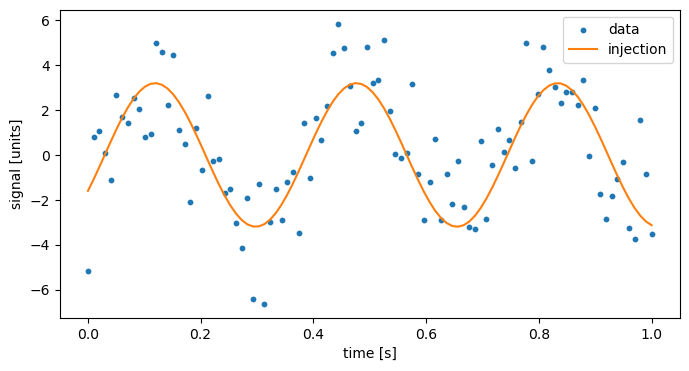

In [4]:
# time samples for data collection
t_start = 0.
t_stop = 1.
Nt = 100
times = jnp.linspace(t_start, t_stop, Nt)

# model data as sinusoid
def model(amp, freq, phase):
    return amp * jnp.sin(2. * jnp.pi * freq * times - phase)

# noise is drawn from zero-mean normal distribution
sigma_inj = 1.8  # standard deviation of the noise
noise_key = jr.key(0)
noise = jr.normal(noise_key, (Nt,)) * sigma_inj

# injected signal and noise parameters
amp_inj = 3.2
freq_inj = 2.8
phase_inj = np.pi / 6.
x_inj = jnp.array([amp_inj, freq_inj, phase_inj, sigma_inj])
ndim = x_inj.shape[0]

# simulate data
signal_inj = model(amp_inj, freq_inj, phase_inj)
data = signal_inj + noise
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', s=10, label='data')
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.show()

# Prior, likelihood, and posterior functions

We use a uniform prior over the signal and noise parameters. The likelihood is

\begin{equation}
p(\mathbf{d}|A, f, \phi, \sigma) \propto \frac{1}{\sigma^{N_t}}\;\text{exp}\bigg[-\frac{1}{2\sigma^2}|\mathbf{d} - \mathbf{h}(A, f, \phi)|^2\bigg]\;.
\end{equation}

In [5]:
# define parameter bounds
amp_min, amp_max = 0., 10.
freq_min, freq_max = 0., 10.
phase_min, phase_max = 0., 2. * np.pi
sigma_min, sigma_max = 0., 10.
x_min = jnp.array([amp_min, freq_min, phase_min, sigma_min])
x_max = jnp.array([amp_max, freq_max, phase_max, sigma_max])

# parameter labels
x_labels = ['A', 'f', r'$\phi$', r'$\sigma$']

# uniform prior
def lnprior(x):
    out_of_bounds = jnp.logical_or(jnp.any(x < x_min),
                                   jnp.any(x > x_max))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.0
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)

In [6]:
# likelihood function
def lnlike(x):
    # unpack parameters
    amp, freq, phase, sigma = x
    signal = model(amp, freq, phase)
    residual = data - signal
    lnlike_val = -0.5 * jnp.sum(residual**2.) / sigma**2. - Nt * jnp.log(sigma)
    return lnlike_val

In [7]:
# make prior and likelihood fast with JIT
fast_lnprior = jit(lnprior)
fast_lnlike = jit(lnlike)

# function to get gradient of likelihood with automatic differentiation
grad_lnlike_fast = jit(grad(fast_lnlike))

In [8]:
%timeit lnlike(x_inj)

76.9 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%timeit fast_lnlike(x_inj)

3.05 µs ± 95.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
%timeit grad_lnlike_fast(x_inj)

14.3 µs ± 1.33 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [11]:
# posterior function
def lnpost(x):
    return fast_lnprior(x) + fast_lnlike(x)

fast_lnpost = jit(lnpost)

In [12]:
# vectorize posterior over multiple inputs
vectorized_lnpost = vmap(fast_lnpost)

# this can do many posterior evaluations quickly
xs = jr.uniform(jr.key(6), (10_000, ndim), minval=x_min, maxval=x_max)
%timeit vectorized_lnpost(xs)

585 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [13]:
# serial evaluation of posterior
%timeit [fast_lnpost(x) for x in xs]

61 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Sample with NumPyro

In [14]:
def sampling_model():

    # define uniform priors on parameters
    amp = numpyro.sample('A', dist.Uniform(amp_min, amp_max))
    freq = numpyro.sample('f', dist.Uniform(freq_min, freq_max))
    phase = numpyro.sample(r'$\phi$', dist.Uniform(phase_min, phase_max))
    sigma = numpyro.sample(r'$\sigma$', dist.Uniform(sigma_min, sigma_max))
    params = jnp.array([amp, freq, phase, sigma])

    # # compact way to define prior over many parameters
    # params = jnp.array([numpyro.sample(x_label, dist.Uniform(min_val, max_val))
    #                     for x_label, min_val, max_val in zip(x_labels, x_min, x_max)])

    # add likelihood factor so we sample the posterior
    numpyro.factor('log_likelihood', fast_lnlike(params))

In [19]:
# define the NUTS sampler
nuts_kernel = NUTS(sampling_model)

# run MCMC
mcmc = MCMC(nuts_kernel,
            num_samples=10_000,
            num_warmup=500)
mcmc.run(jr.key(2))

# get posterior samples
HMC_samples = mcmc.get_samples()

# convert samples to multi-dimensional numpy-array instead of dictionary
HMC_samples = np.array([HMC_samples[key] for key in x_labels]).T
num_HMC_samples = len(HMC_samples)

sample: 100%|██████████| 10500/10500 [00:02<00:00, 4918.96it/s, 7 steps of size 3.21e-01. acc. prob=0.95]


# Sample with Metropolis-Hastings for comparison

In [20]:
# simple Metropolis-Hastings MCMC for comparison
def MH_MCMC(num_samples, x0, lnpost_func):

    # initialize samples
    ndim = x0.shape[0]
    samples = np.zeros((num_samples, ndim))
    lnposts = np.zeros(num_samples)
    samples[0] = x0
    lnposts[0] = lnpost_func(samples[0])

    # get Fisher jumps
    def get_Fisher_jumps(x):
        Fisher = -hessian(lnpost_func)(x)  # automatic differentiation!
        vals, vecs = jnp.linalg.eigh(Fisher)
        jumps = jnp.array([1. / jnp.sqrt(val) * vec for val, vec in zip(vals, vecs.T)])
        return jumps
    fast_Fisher_jumps = jit(get_Fisher_jumps)

    # get differential evolution jumps
    DE_scale = 2.38 / jnp.sqrt(2. * ndim)
    def DE_jump(samples, iteration, key):
        choice_key, weight_key = jr.split(key)
        choice_ndxs = jr.choice(choice_key, iteration, (2,))
        jump = samples[choice_ndxs[0]] - samples[choice_ndxs[1]]
        jump *= jr.normal(weight_key) * DE_scale
        return jump

    # track jump acceptance rates
    num_jump_types = 2
    jump_accept_counts = np.zeros(num_jump_types)
    jump_reject_counts = np.zeros(num_jump_types)

    # jump choices
    jump_choices = np.random.choice(num_jump_types, num_samples, p=np.array([0.6, 0.4]))

    # initialize Fisher jumps
    Fisher_jumps = fast_Fisher_jumps(samples[0])

    # main MCMC loop
    for i in range(num_samples - 1):

        # update progress
        if i % (num_samples // 1000) == 0:
            print(f'{round(i / num_samples * 100, 3)}%', end='\r')
        
        # update Fisher occasionally
        if i % 10_000 == 0 and i > 100:
            x_ML_so_far = samples[jnp.argmax(lnposts[:i])]
            Fisher_jumps = fast_Fisher_jumps(x_ML_so_far)

        # jump proposal
        jump_key = jr.PRNGKey(i)
        jump_ndx = jump_choices[i]
        if jump_ndx == 0 or i < 100:  # Fisher jump
            direction_key, weight_key = jr.split(jump_key)
            jump = Fisher_jumps[jr.choice(direction_key, ndim)] * jr.normal(weight_key)
        else:
            jump = DE_jump(samples, i, jump_key)
        
        # decide to accept or reject proposal
        new_state = samples[i] + jump
        new_lnpost = lnpost_func(new_state)
        accept_prob = jnp.exp(new_lnpost - lnposts[i])
        
        if jr.uniform(jump_key) < accept_prob:  # accept
            samples[i + 1] = np.copy(new_state)
            lnposts[i + 1] = np.copy(new_lnpost)
            jump_accept_counts[jump_ndx] += 1
        else:  # reject
            samples[i + 1] = np.copy(samples[i])
            lnposts[i + 1] = np.copy(lnposts[i])
            jump_reject_counts[jump_ndx] += 1
        
    # compute acceptance rate
    jump_accept_rates = np.round(jump_accept_counts / (jump_accept_counts + jump_reject_counts), 3)
    print('jump acceptance rates')
    print(f'Fisher: {jump_accept_rates[0]}')
    print(f'DE: {jump_accept_rates[1]}')

    return samples, lnposts

In [22]:
# run Metropolis-Hastings MCMC
num_samples = int(1e5)
MH_samples, MH_lnposts = MH_MCMC(num_samples=num_samples,
                                 x0=x_inj,
                                 lnpost_func=fast_lnpost)

jump acceptance rates
Fisher: 0.711
DE: 0.484


# post-processing

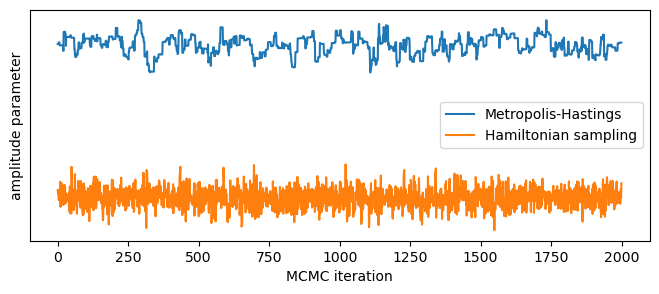

In [23]:
# plot chains for one parameter
# notice auto-correlation is much lower for HMC chain
plt.figure(figsize=(8,3))
plt.plot(MH_samples[-num_HMC_samples//5:,0], color='C0', label='Metropolis-Hastings')
plt.plot(HMC_samples[-num_HMC_samples//5:,0] - 4, color='C1', label='Hamiltonian sampling')
plt.yticks([])
plt.xlabel('MCMC iteration')
plt.ylabel('amplitude parameter')
plt.legend()
plt.show()

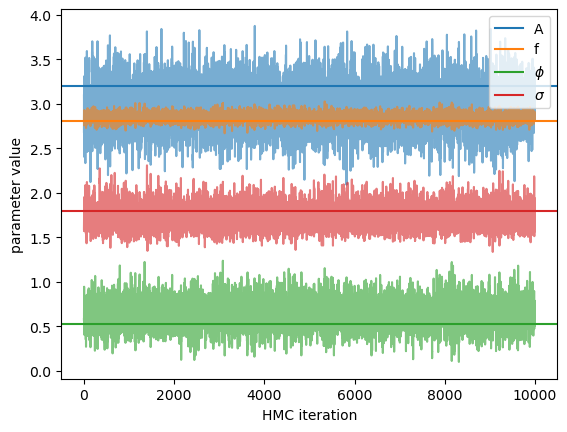

In [24]:
# trace plot for all parameters using HMC
for i in range(ndim):
    plt.plot(HMC_samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(x_inj[i], color=f'C{i}', label=x_labels[i])
plt.xlabel('HMC iteration')
plt.ylabel('parameter value')
plt.legend(loc='upper right')
plt.show()

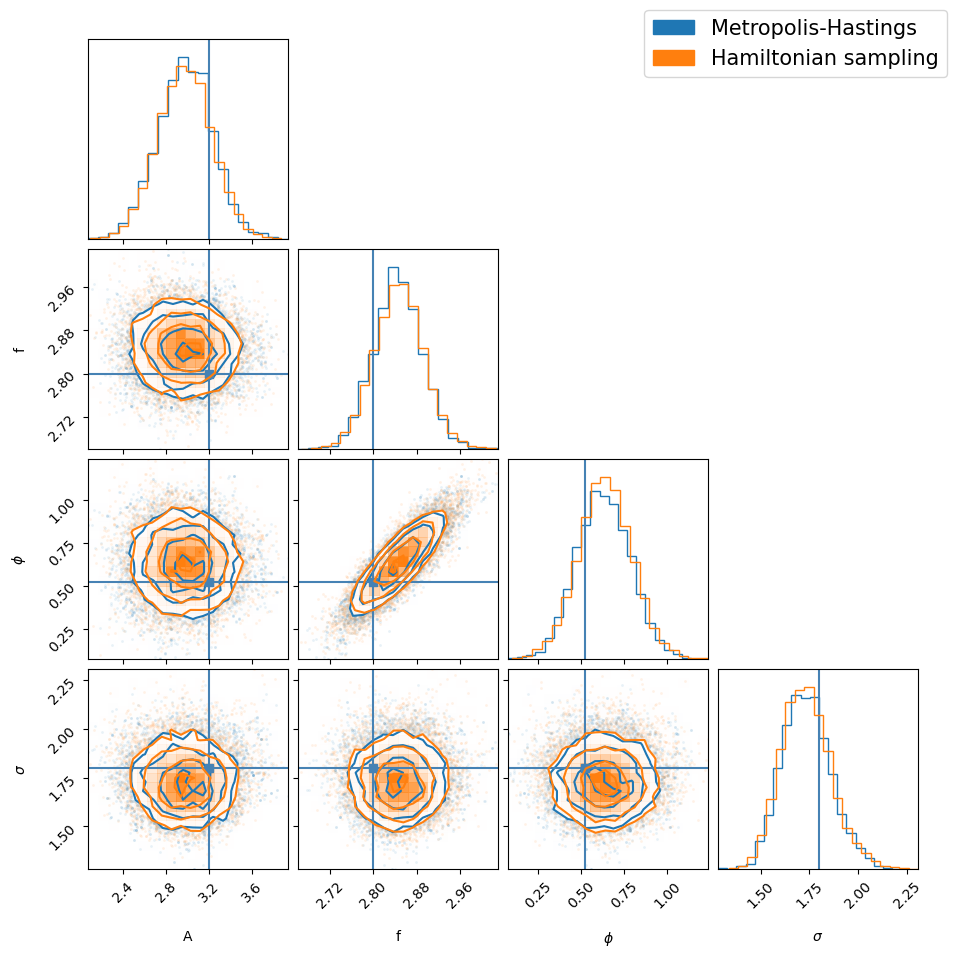

In [25]:
# thin MH samples so they're same size as HMC samples
burnin = MH_samples.shape[0] // 2
thinning_ndxs = np.random.choice(np.arange(burnin, MH_samples.shape[0]),
                                 size=num_HMC_samples,
                                 replace=False)

# plot posteriors
fig = corner(MH_samples[thinning_ndxs], 
             truths=x_inj, 
             labels=x_labels,
             color='C0')

# plot HMC samples
corner(HMC_samples,
       color='C1',
       fig=fig)

MH_patch = mpatches.Patch(color='C0', label='Metropolis-Hastings')
HMC_patch = mpatches.Patch(color='C1', label='Hamiltonian sampling')
fig.legend(handles=[MH_patch, HMC_patch],
           loc='upper right',
           fontsize=15)
plt.show()

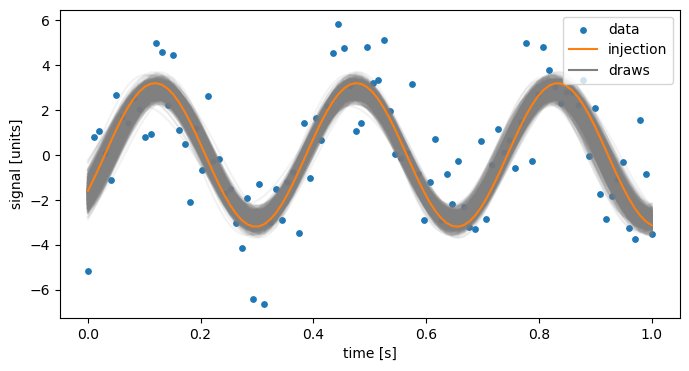

In [27]:
# Bayesogram
num_draws = 1000
fair_draw_ndxs = np.random.choice(num_HMC_samples, size=num_draws)
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', s=15, label='data')
[plt.plot(times, model(*x), color='grey', alpha=0.1) 
for x in HMC_samples[fair_draw_ndxs, :-1]]
plt.plot(times, signal_inj, color='C1', label='injection')
plt.plot([], [], color='grey', label='draws')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='upper right')
plt.show()

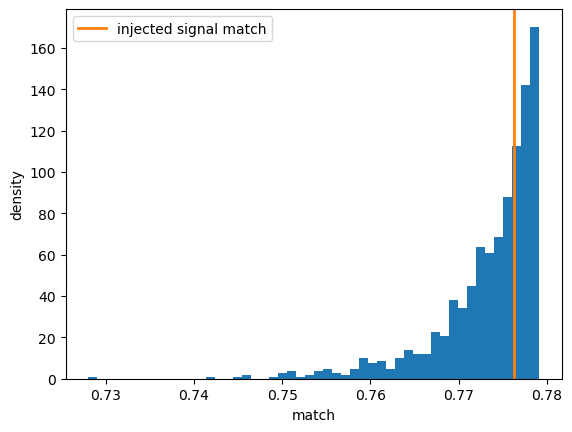

In [29]:
# compute match
data_power = jnp.sum(data**2.)
def match(x):
    signal = model(*x[:-1])
    match_val = jnp.sum(data * signal) / jnp.sqrt(data_power * jnp.sum(signal**2.))
    return match_val
vectorized_match = jit(vmap(match))

plt.hist(vectorized_match(HMC_samples[fair_draw_ndxs]), bins=50, density=True)
plt.axvline(match(x_inj),
            color='C1',
            label='injected signal match', lw=2)
plt.xlabel('match')
plt.ylabel('density')
plt.legend()
plt.show()